[![Open In colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/APIs/1_APIs_Geograficas/clase-1.ipynb)

# Clase 1: APIs geográficas

In [1]:
#vamos a escribit en lineas de comando de bash, lo que vamos a instalar una libreria
!pip install geopandas

     |████████████████████████████████| 972kB 8.5MB/s 
     |████████████████████████████████| 14.8MB 305kB/s 
     |████████████████████████████████| 6.5MB 40.5MB/s 


In [2]:
import requests
import pandas as pd
import geopandas as gpd
#no podemos correr la desde el collab, solo podemos correr esta linea en la pc
#no podemos ejecutarla en collab pero si localmente.
#import helpers
import json

In [3]:
#copiamos el archivo helpers a mano

import pandas as pd
import requests


def normalizar_unidades_territoriales(
        entidades, entidades_tipo, nombre_campo=None,
        provincia_campo=None, chunk_size=1000
):
    '''Normaliza unidades territoriales usando la API Georef.
    Args:
        entidades (list or pd.DataFrame): Una lista con nombres de entidades a
            normalizar, o un dataframe con columnas donde 'nombre_campo' es la
            que contiene los nombres a normalizar, y 'provincia_campo'
            (opcional) contiene el nombre del campo provincia, para mejorar el
            resultado de la normalizacion.
        entidades_tipo (str): Nombre del tipo de entidades a normalizar, puede
            ser uno de: 'provincias', 'departamentos', 'localidades' o
            'municipios'.
        nombre_campo (str): Debe especificarse si 'entidades' es un dataframe.
            Indica cual es el campo que contiene los nombres a normalizar.
        provincia_campo (str): Opcional. Indica cual es el campo que contiene
            los nombres de las provincias. Ayuda a mejorar la precision de la
            normalizacion de unidades mas chicas que provincias.
    Return:
        pd.DataFrame: Nombres y codigos oficiales de las entidades normalizadas.
    '''

    # genera un array vacio para guardar los resultados de cada request
    resultados = []

    # genera un resultado nulo para reemplazar los casos que no funcionen
    resultado_nulo = {
        'id': None,
        'nombre': None,
    }
    if provincia_campo:
        resultado_nulo['provincia_id'] = None
        resultado_nulo['provincia_nombre'] = None

    # genera el JSON con la lista de consultas a realizar
    for i in range(0, len(entidades), chunk_size):
        start, end = i, i + chunk_size

        # el final no puede ser mayor a la cantidad de entidades
        if end > len(entidades):
            end = len(entidades)

        data = {entidades_tipo: []}

        # si se pasa una lista, contiene los nombres a normalizar
        if isinstance(entidades, list):
            for nombre in entidades[start:end]:
                consulta = {
                    'nombre': nombre,
                    'max': 1,
                    'campos': 'id,nombre'
                }
                data[entidades_tipo].append(consulta)

        # si no se pasa una lista, debe haber un nombre de campo que contenga
        # los nombres a normalizar, y puede haber una columna de provincia
        elif nombre_campo:
            for entidad in entidades.to_dict('record')[start:end]:
                consulta = {
                    'nombre': entidad[nombre_campo],
                    'max': 1,
                    'campos': 'id,nombre',
                    'aplanar': True
                }
                if provincia_campo:
                    consulta['provincia'] = entidad[provincia_campo]
                    consulta['campos'] = 'id,nombre,provincia.id,provincia.nombre'

                data[entidades_tipo].append(consulta)
        else:
            print('Error en la definicion de la consulta')
            return

        try:
            # realiza la consulta
            resultados_parciales = requests.post(
                f"https://apis.datos.gob.ar/georef/api/{entidades_tipo}",
                json=data
            ).json()['resultados']

            for resultado in resultados_parciales:
                if resultado and resultado[entidades_tipo] and len(resultado[entidades_tipo]) != 0:
                    resultados.append(resultado[entidades_tipo][0])
                else:
                    resultados.append(resultado_nulo)

        except Exception as e:
            print(f'No se pudo normalizar el bloque {start} a {end}. '
                  'Reemplazando por resultados nulos.')
            print(e)
            resultados.extend([resultado_nulo] * (end - start))

    return pd.DataFrame(resultados)


def georreferenciar_direcciones(
        entidades, nombre_campo=None,
        provincia_campo=None, chunk_size=1000,
        output_as_dataframe=True
):
    '''Normaliza unidades territoriales usando la API Georef.
    Args:
        entidades (pd.DataFrame): Una lista de direcciones a georreferenciar
            donde 'nombre_campo' es la que contiene las direcciones, y
            'provincia_campo' (opcional) contiene el nombre del campo provincia,
            para mejorar el resultado de la normalizacion.
        nombre_campo (str): Indica cual es el campo que contiene los nombres a
            normalizar.
        provincia_campo (str): Opcional. Indica cual es el campo que contiene
            los nombres de las provincias. Ayuda a mejorar la precision de la
            normalizacion de unidades mas chicas que provincias.
    Return:
        pd.DataFrame: Nombres y codigos oficiales de las entidades normalizadas.
    '''

    # genera un array vacio para guardar los resultados de cada request
    resultados = []

    # genera un resultado nulo para reemplazar los casos que no funcionen
    resultado_nulo = {
        'direccion_normalizada': None,
        'latitud': None,
        'longitud': None,
    }

    # genera el JSON con la lista de consultas a realizar
    for i in range(0, len(entidades), chunk_size):
        start, end = i, i + chunk_size

        # el final no puede ser mayor a la cantidad de entidades
        if end > len(entidades):
            end = len(entidades)

        data = {'direcciones': []}

        # si no se pasa una lista, debe haber un nombre de campo que contenga
        # los nombres a normalizar, y puede haber una columna de provincia
        for entidad in entidades.to_dict('record')[start:end]:
            consulta = {
                'direccion': entidad[nombre_campo],
                'max': 1,
                'campos': 'nomenclatura,ubicacion.lat,ubicacion.lon,provincia.id,provincia.nombre',
                'aplanar': True
            }
            if provincia_campo:
                consulta['provincia'] = entidad[provincia_campo]

            data['direcciones'].append(consulta)

        try:
            # realiza la consulta
            resultados_parciales = requests.post(
                f"https://apis.datos.gob.ar/georef/api/direcciones",
                json=data
            ).json()['resultados']

            for resultado in resultados_parciales:
                if resultado and resultado['direcciones'] and len(resultado['direcciones']) != 0:
                    resultado_parseado = {
                        'direccion_normalizada': resultado['direcciones'][0]['nomenclatura'],
                        'latitud': resultado['direcciones'][0]['ubicacion_lat'],
                        'longitud': resultado['direcciones'][0]['ubicacion_lon'],
                        'provincia_id': resultado['direcciones'][0]['provincia_id'],
                        'provincia_nombre': resultado['direcciones'][0]['provincia_nombre']
                    }

                    resultados.append(resultado_parseado)
                else:
                    resultados.append(resultado_nulo)

        except Exception as e:
            if chunk_size > 1:
                for j in range(start, end, int(chunk_size / 2)):
                    start_j, end_j = j, j + chunk_size
                    resultados_parciales = georreferenciar_direcciones(
                        entidades, nombre_campo=nombre_campo,
                        provincia_campo=provincia_campo, chunk_size=chunk_size,
                        output_as_dataframe=False
                    )
                    resultados.extend(resultados_parciales)
            else:
                print(f'No se pudo normalizar el bloque {start} a {end}. '
                      'Reemplazando por resultados nulos.')
                print(e)
                resultados.extend([resultado_nulo] * (end - start))

    if output_as_dataframe:
        return pd.DataFrame(resultados)
    else:
        return resultados


def ubicar_coordenadas(entidades, latitud_campo, longitud_campo,
                       chunk_size=1000):
    '''Normaliza unidades territoriales usando la API Georef.
    Args:
        entidades (pd.DataFrame): Una lista de coordenadas a ubicar donde
            'latitud_campo' es el nombre de la columna que tiene la latitud y
            'longitud_campo' la columna que tiene la longitud. Las coordenadas
            deben estar en numeros decimales y en el sistema de referencia
            EPSG 4326.
        latitud_campo (str): Nombre del campo que tiene la latitud.
        longitud_campo (str): Nombre del campo que tiene la longitud.
    Return:
        pd.DataFrame: Nombres y codigos oficiales de las unidades territoriales
            que contienen a las coordenadas.
    '''

    # genera un array vacio para guardar los resultados de cada request
    resultados = []

    # genera un resultado nulo para reemplazar los casos que no funcionen
    resultado_nulo = {
        'provincia_id': None,
        'provincia_nombre': None,
        'departamento_id': None,
        'departamento_nombre': None,
        'municipio_id': None,
        'municipio_nombre': None,
    }

    # genera el JSON con la lista de consultas a realizar
    for i in range(0, len(entidades), chunk_size):
        start, end = i, i + chunk_size

        # el final no puede ser mayor a la cantidad de entidades
        if end > len(entidades):
            end = len(entidades)

        data = {'ubicaciones': []}

        # si no se pasa una lista, debe haber un nombre de campo que contenga
        # los nombres a normalizar, y puede haber una columna de provincia
        for entidad in entidades.to_dict('record')[start:end]:
            consulta = {
                'lat': entidad[latitud_campo],
                'lon': entidad[longitud_campo],
                'campos': 'provincia.id,provincia.nombre,departamento.id,departamento.nombre,municipio.id,municipio.nombre,',
                'aplanar': True
            }

            data['ubicaciones'].append(consulta)

        # try:
        # realiza la consulta
        response = requests.post(
            f"https://apis.datos.gob.ar/georef/api/ubicacion",
            json=data
        ).json()
        resultados_parciales = response['resultados']

        for resultado in resultados_parciales:
            if resultado and resultado['ubicacion'] and len(resultado['ubicacion']) != 0:
                resultado_parseado = {
                    'provincia_id': resultado['ubicacion']['provincia_id'],
                    'provincia_nombre': resultado['ubicacion']['provincia_nombre'],
                    'departamento_id': resultado['ubicacion']['departamento_id'],
                    'departamento_nombre': resultado['ubicacion']['departamento_nombre'],
                    'municipio_id': resultado['ubicacion']['municipio_id'],
                    'municipio_nombre': resultado['ubicacion']['municipio_nombre'],
                }

                resultados.append(resultado_parseado)
            else:
                resultados.append(resultado_nulo)

        # except Exception as e:
        #     print(f'No se pudo normalizar el bloque {start} a {end}. '
        #           'Reemplazando por resultados nulos.')
        #     print(e)
        #     resultados.extend([resultado_nulo] * (end - start))

    return pd.DataFrame(resultados)

## Requests

### Interfaces de aplicaciones

¿Qué es una API? Los sistemas tienen distintos tipos de interfaces que permiten interactuar con ellos.

* **GUI (Graphical User Interface)**: El usuario clickea e interactúa con distintos objetos para ejecutar acciones y lograr sus objetivos. Las páginas web tienen interfaces gráficas.
* **API (Application Programming Interface)**: El usuario escribe líneas de código para interactuar con el sistema, ejecutar acciones y lograr sus objetivos.

Todos los sitios web tienen una interfaz gráfica con la que estamos acostumbrados a interactuar, y también tienen una interfaz de programación más o menos desarrollada, o más o menos expuesta, con la cual tal vez no estemos tan acostumbrados a interactuar.

Ejemplo: 

Si van a https://www.mercadolibre.com.ar/ pueden hacer click en un input box, escribir "pelotas", apretar "Enter" y el sistema les devolverá el resultado de una búsqueda. Si lo cambian por "pelotas futbol" y hacen "Enter" de nuevo, cambiará el resultado de la búsqueda. Esta es la **interfaz gráfica del sitio**.

Sin embargo también podrían cumplir el mismo objetivo sólo escribiendo distintas URLs en el navegador:

* https://listado.mercadolibre.com.ar/pelotas
* https://listado.mercadolibre.com.ar/pelotas-futbol

Esto es más parecido a lo que llamaríamos una **interfaz de programación**.

### APIs REST

En la web, las interfaces de programación de uso más difundido son las APIs REST ([Representational state transfer](https://es.wikipedia.org/wiki/Transferencia_de_Estado_Representacional)) que especifica protocolos y métodos para interactuar con los vastos recursos de internet, escribiendo líneas de código.

La web utiliza ampliamente el protocolo HTTP para interactuar con sus recursos. Este protocolo indica cómo estructurar un mensaje de texto que describa la petición (**request**) del usuario a un servidor. Hay distintos tipos de peticios que un usuario puede realizar, algunas de ellas son:

* **GET**: Solicita una representación de un recurso alojado en el servidor.
* **POST**: Envía datos al servidor para crear un recurso nuevo.
* **PUT**: Crea o modifica un recurso del servidor.
* **DELETE**: Elimina un recurso del servidor.

Existen otros métodos que hoy no nos interesan.

### GET request 

Cada vez que vamos al navegador y escribimos la dirección de una página web, **estamos haciendo un GET request** a un servidor. Esto es una petición para adquirir el código de un recurso que queremos visualizar en el navegador. 

La URL es la parte más importante de la definición de un GET request (aunque el navegador agrega otras cosas también, que no vemos) y nos permite cambiar la representación deseada de ese mismo recurso de distintas maneras:

* https://deportes.mercadolibre.com.ar/pelotas-futbol pide al servidor pelotas de fútbol.
* https://deportes.mercadolibre.com.ar/pelotas-futbol_OrderId_PRICE pide al servidor pelotas de fútbol ordenadas por precio.

Cuando escribimos una URL en un navegador, la mayoría de las veces hacemos GET requests que devuelven código HTML (es el código que usa el navegador para renderizar una página web) pero las GET requests pueden devolver datos en otros formatos (por ejemplo en JSON y en CSV). 

**Las APIs REST que definen GET requests capaces de devolver datos en formato JSON y CSV, son particularmente interesantes para enriquecer nuestras capacidades de análisis de datos.**

Ahora vamos a conocer algunas de ellas.

## API Georef 

La [API Georef](http://apis.datos.gob.ar/georef) o, en su nombre más largo, el **Servicio de Normalización de Datos Geográficos de Argentina** es una API REST desarrollada y mantenida por el Estado Nacional de Argentina para la normalización de datos geográficos, que es capaz de:

* Georreferenciar una dirección
* Normalizar nombres de provincias, departamentos y otras entidades
* Devolver los nombres de provincias, departamentos y otras entidades que contienen a un par de coordenadas (georreferenciación inversa)
* Sirve de referencia, devolviendo las listas canónicas con nombres y códigos oficiales de estas entidades, en formato CSV, JSON, SHP y otros.

A continuación, vamos a ver algunos de los usos que tienen los recursos de esta API para potenciar nuestras capacidades de analizar datos.

### Referencia 

La API Georef contiene las listas con nombres y códigos oficiales de Argentina para, entre otras, las siguientes entidades:

* Provinicias
* Departamentos
* Municipios
* Localidades
* Calles

Cada una de ellas se consulta usando un **recurso** de la API.

#### Librería `requests` y formato JSON

Si estuviéramos desarrollando una aplicación web que contiene, por ejemplo, un formulario donde el usurio debe elegir el nombre de la provincia donde vive con el objeto de guardar la información en una base de datos, podríamos usar la API Georef para obtener esa lista.

La librería `requests` en python permite hacer todo tipo de requests APIs REST y es sencilla de utilizar.

In [5]:
response = requests.get("https://apis.datos.gob.ar/georef/api/provincias")

In [6]:
# el status code de una request indica si esta fue realizada con éxito o no, y por qué
# el código 200 indica que una request fue realizada exitosamente
response.status_code

200

In [7]:
provincias = response.json()
provincias

{'cantidad': 24,
 'inicio': 0,
 'parametros': {},
 'provincias': [{'centroide': {'lat': -26.8753965086829,
    'lon': -54.6516966230371},
   'id': '54',
   'nombre': 'Misiones'},
  {'centroide': {'lat': -33.7577257449137, 'lon': -66.0281298195836},
   'id': '74',
   'nombre': 'San Luis'},
  {'centroide': {'lat': -30.8653679979618, 'lon': -68.8894908486844},
   'id': '70',
   'nombre': 'San Juan'},
  {'centroide': {'lat': -32.0588735436448, 'lon': -59.2014475514635},
   'id': '30',
   'nombre': 'Entre Ríos'},
  {'centroide': {'lat': -48.8154851827063, 'lon': -69.9557621671973},
   'id': '78',
   'nombre': 'Santa Cruz'},
  {'centroide': {'lat': -40.4057957178801, 'lon': -67.229329893694},
   'id': '62',
   'nombre': 'Río Negro'},
  {'centroide': {'lat': -43.7886233529878, 'lon': -68.5267593943345},
   'id': '26',
   'nombre': 'Chubut'},
  {'centroide': {'lat': -32.142932663607, 'lon': -63.8017532741662},
   'id': '14',
   'nombre': 'Córdoba'},
  {'centroide': {'lat': -34.6298873058957, '

El método `response.json()` de la librería `requests` devuelve una respuesta de formato JSON, en un familiar diccionario de python.

In [8]:
provincias["provincias"][0]

{'centroide': {'lat': -26.8753965086829, 'lon': -54.6516966230371},
 'id': '54',
 'nombre': 'Misiones'}

Las APIs tienen distintos parámetros que permiten modificar la consulta a un recurso determinado, estos se agregan al final usando un signo de interrogación `?` y separándolos con el caracter _ampersand_ `&`.

* **Recurso**: apis.datos.gob.ar/georef/api/provincias
* **Parámetros**: ?orden=nombre&aplanar
* **URL completa**: apis.datos.gob.ar/georef/api/provincias?orden=nombre&aplanar

El parámetro "orden" permite elegir un campo por el cual ordenar los resultados. El parámetro "aplanar" devuelve una estructura plana o no anidada de los resultados que a veces es más fácil de utilizar, dependiendo de lo que estemos haciendo.

Podés consultar los otros parámetros disponibles para el recurso "provincias" en https://datosgobar.github.io/georef-ar-api/open-api/#/Recursos/get_provincias

**Ejercicio:** crea una lista ordenada alfabéticamente con tuplas que contengan id y nombre de cada provincia, que usarías para armar tu selector de provincias en una página web.

In [9]:
listaProv = requests.get("https://apis.datos.gob.ar/georef/api/provincias")
listaProv = listaProv.json()
listaProv['provincias'][0]

{'centroide': {'lat': -26.8753965086829, 'lon': -54.6516966230371},
 'id': '54',
 'nombre': 'Misiones'}

In [10]:
(listaProv['provincias'][0]['id'],listaProv['provincias'][0]['nombre'])

('54', 'Misiones')

In [11]:
tamanoLista = len(listaProv['provincias'])
tamanoLista

24

In [12]:
miLista=[]
for provinciaItem in listaProv['provincias']:
  miLista.append((provinciaItem['id'],provinciaItem['nombre']))

miListaOrdenada = sorted(miLista, key = lambda provincia:provincia[1])
miListaOrdenada


[('06', 'Buenos Aires'),
 ('10', 'Catamarca'),
 ('22', 'Chaco'),
 ('26', 'Chubut'),
 ('02', 'Ciudad Autónoma de Buenos Aires'),
 ('18', 'Corrientes'),
 ('14', 'Córdoba'),
 ('30', 'Entre Ríos'),
 ('34', 'Formosa'),
 ('38', 'Jujuy'),
 ('42', 'La Pampa'),
 ('46', 'La Rioja'),
 ('50', 'Mendoza'),
 ('54', 'Misiones'),
 ('58', 'Neuquén'),
 ('62', 'Río Negro'),
 ('66', 'Salta'),
 ('70', 'San Juan'),
 ('74', 'San Luis'),
 ('78', 'Santa Cruz'),
 ('82', 'Santa Fe'),
 ('86', 'Santiago del Estero'),
 ('94', 'Tierra del Fuego, Antártida e Islas del Atlántico Sur'),
 ('90', 'Tucumán')]

In [13]:
#metodo alternativo pidiendo a la api que de el resultado ordenado
response = requests.get("https://apis.datos.gob.ar/georef/api/provincias?orden=nombre")
provincias = response.json()
#aca tengo el diccionario con la lista ordenada por nombre de provincia
[(prov['id'], prov['nombre']) for prov in provincias['provincias']]


[('06', 'Buenos Aires'),
 ('10', 'Catamarca'),
 ('22', 'Chaco'),
 ('26', 'Chubut'),
 ('02', 'Ciudad Autónoma de Buenos Aires'),
 ('14', 'Córdoba'),
 ('18', 'Corrientes'),
 ('30', 'Entre Ríos'),
 ('34', 'Formosa'),
 ('38', 'Jujuy'),
 ('42', 'La Pampa'),
 ('46', 'La Rioja'),
 ('50', 'Mendoza'),
 ('54', 'Misiones'),
 ('58', 'Neuquén'),
 ('62', 'Río Negro'),
 ('66', 'Salta'),
 ('70', 'San Juan'),
 ('74', 'San Luis'),
 ('78', 'Santa Cruz'),
 ('82', 'Santa Fe'),
 ('86', 'Santiago del Estero'),
 ('94', 'Tierra del Fuego, Antártida e Islas del Atlántico Sur'),
 ('90', 'Tucumán')]

#### `pandas` y formato CSV 

Si estamos creando una tabla auxiliar o de consulta para obtener los nombres y códigos oficiales de las provincias, es posible que queramos descargarla en CSV o leerla directamente en un dataframe de pandas.

In [14]:
df = pd.read_csv('https://apis.datos.gob.ar/georef/api/provincias?formato=csv')

In [15]:
df
#es la unidad fundamental de la libreria pandas. En la api podemos
#cambiar el formato por csv en ese caso en lugar de devolver el json 
#devuelve un tabla que puedo leer con pandas. 

,provincia_id,provincia_nombre,provincia_centroide_lat,provincia_centroide_lon
0,54,Misiones,-26.875397,-54.651697
1,74,San Luis,-33.757726,-66.028130
2,70,San Juan,-30.865368,-68.889491
3,30,Entre Ríos,-32.058874,-59.201448
4,78,Santa Cruz,-48.815485,-69.955762
5,62,Río Negro,-40.405796,-67.229330
6,26,Chubut,-43.788623,-68.526759
7,14,Córdoba,-32.142933,-63.801753
8,50,Mendoza,-34.629887,-68.583123
9,46,La Rioja,-29.685776,-67.181736


Notá que la respuesta viene "aplanada" por defecto, ya que el CSV es un formato tabular (no anidado).

**Ejercicio:** crea una tabla con la lista de departamentos de la provincia de Santa Fé. Para esto usa el recurso "departamentos" y el parámetro "provincia" para filtrarlo con los resultados de la provincia de Santa Fé. 

Puedes usar tanto el id como el nombre de la provincia para filtrar.

In [47]:
#realizamos la consulta por la provincia de Santa Fe
dfDepartamentosSantaFe = pd.read_csv("https://apis.datos.gob.ar/georef/api/departamentos?formato=csv&provincia=Santa%20Fe&max=5000")
dfDepartamentosSantaFe

,departamento_id,departamento_nombre,departamento_centroide_lat,departamento_centroide_lon,provincia_id,provincia_nombre
0,82028,Villa Constitución,-33.485583,-60.851384,82,Santa Fe
1,82063,La Capital,-31.475356,-60.669479,82,Santa Fe
2,82133,Vera,-28.969929,-60.413543,82,Santa Fe
3,82077,9 de Julio,-28.849605,-61.398354,82,Santa Fe
4,82035,Garay,-31.054641,-60.125808,82,Santa Fe
5,82070,Las Colonias,-31.315338,-61.109481,82,Santa Fe
6,82098,San Javier,-30.104146,-59.898070,82,Santa Fe
7,82014,Caseros,-33.221497,-61.531016,82,Santa Fe
8,82084,Rosario,-33.127856,-60.710842,82,Santa Fe
9,82119,San Lorenzo,-32.942315,-60.961501,82,Santa Fe


In [48]:
#consultamos por dos provincias, pero ojo debemos hacerlo con el id no el nombre de provincia.
dfDepartamentoChubutSantaCruz = pd.read_csv('https://apis.datos.gob.ar/georef/api/departamentos?provincia=26,78&orden=nombre&formato=csv&max=5000')
dfDepartamentoChubutSantaCruz

,departamento_id,departamento_nombre,departamento_centroide_lat,departamento_centroide_lon,provincia_id,provincia_nombre
0,26007,Biedma,-42.443635,-64.933226,26,Chubut
1,78007,Corpen Aike,-49.947484,-69.446951,78,Santa Cruz
2,26014,Cushamen,-42.366353,-70.712012,26,Chubut
3,78014,Deseado,-47.330519,-68.029079,78,Santa Cruz
4,26021,Escalante,-45.282788,-67.708757,26,Chubut
5,26028,Florentino Ameghino,-44.423269,-66.130067,26,Chubut
6,26035,Futaleufú,-43.070541,-71.455376,26,Chubut
7,26042,Gaiman,-43.272762,-66.172162,26,Chubut
8,26049,Gastre,-42.749069,-68.802322,26,Chubut
9,78021,Güer Aike,-51.413413,-70.561816,78,Santa Cruz


#### `geopandas` y el formato SHP (shapefile) 

In [49]:
#el formato shapefile, tenemos un tabla como en un csv pero ademas tenemos unas columnas
#mas con las geometrias de las unidades territoriales.
#es un archivo .zip que adentro tiene varios archivos. Si tenemos la url lo puedo leer
#usando geopanda, de una forma muy similar. Hago la misma consulta pero en formato shp
#lo bueno de la libreria es que ya nos permite graficarlos.
#ojo al graficar aparecen algunos agujeros en la provincia de santa fe por el max.

La API georef también permite obtener las geometrías de las entidades para, por ejemplo, graficarlas en un mapa. Sólo debe cambiarse el formato por "shp".

Geopandas puede leer un shapefile directo de la URL, tal como hicimos con el CSV.

In [50]:
gdf = gpd.read_file('https://apis.datos.gob.ar/georef/api/departamentos?formato=shp&provincia=82')

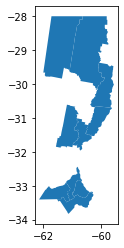

In [51]:
gdf.plot()

In [52]:
len(gdf)

10

Por qué faltan departamentos? La API devuelve 10 resultados como máximo por defecto, pero se puede aumentar la cantidad de resultados con el parámetro "max" hasta 5000.

In [53]:
gdf = gpd.read_file('https://apis.datos.gob.ar/georef/api/departamentos?formato=shp&provincia=82&max=5000')

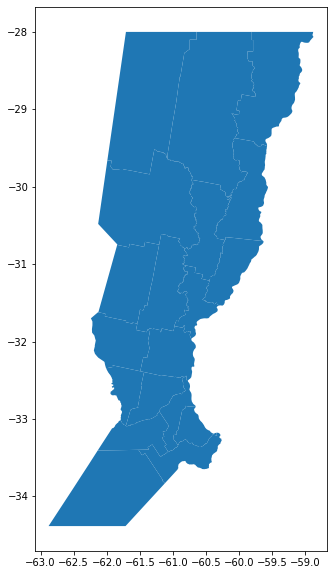

In [54]:
gdf.plot(figsize=(10, 10))

**Ejercicio:** crea un mapa de los departamentos de la provincia de Buenos Aires. Y luego crea otro solamente de aquellos departamentos con nombres de santos.

Podés usar el parámetro "nombre" para filtrar los nombres de los departamentos que contengan la palabra "san".

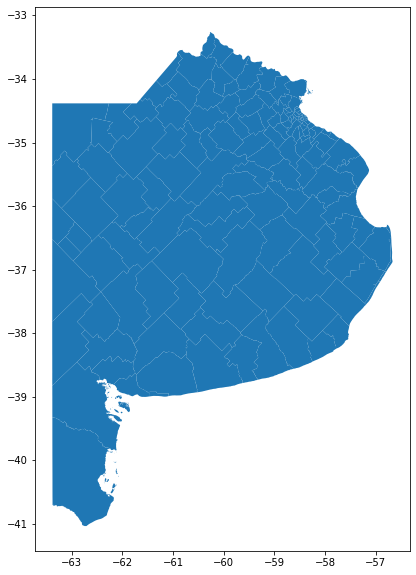

In [58]:
gdf = gpd.read_file('https://apis.datos.gob.ar/georef/api/departamentos?formato=shp&provincia=Buenos%20Aires&max=5000')
gdf.plot(figsize=(10,10))

,centr_lon,id,prov_nombre,nombre,prov_id,centr_lat,geometry
0,-59.7825917634816,06770,Buenos Aires,San Pedro,06,-33.7819425849294,"POLYGON ((-59.83077 -33.58028, -59.83022 -33.5..."
1,-59.5866369475028,06742,Buenos Aires,San Cayetano,06,-38.3886180658492,"POLYGON ((-59.62606 -38.04229, -59.62519 -38.0..."
2,-60.292953731623,06763,Buenos Aires,San Nicolás,06,-33.4825541340452,"POLYGON ((-60.26319 -33.25989, -60.25421 -33.2..."
3,-58.6917055208826,06760,Buenos Aires,San Miguel,06,-34.5520919648351,"POLYGON ((-58.60621 -34.53442, -58.60690 -34.5..."
4,-58.4319219645129,06778,Buenos Aires,San Vicente,06,-35.0704596398936,"POLYGON ((-58.31664 -34.92587, -58.30244 -34.9..."
5,-58.5372648522523,06756,Buenos Aires,San Isidro,06,-34.4869499670191,"POLYGON ((-58.51440 -34.44592, -58.51504 -34.4..."
6,-58.5459540333809,06749,Buenos Aires,San Fernando,06,-34.1512700249506,"MULTIPOLYGON (((-58.42784 -34.00408, -58.42780..."
7,-59.4732938848478,06728,Buenos Aires,San Andrés de Giles,06,-34.4377851586384,"POLYGON ((-59.35704 -34.24458, -59.29826 -34.2..."
8,-59.5193792218302,06735,Buenos Aires,San Antonio de Areco,06,-34.2206591685119,"POLYGON ((-59.32172 -33.99608, -59.32140 -33.9..."
9,-58.5643145358763,06371,Buenos Aires,Ciudad Libertador San Martín,06,-34.5526490761118,"POLYGON ((-58.54629 -34.53662, -58.53775 -34.5..."


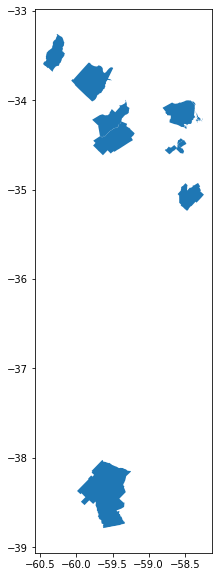

In [60]:
gdf = gpd.read_file('https://apis.datos.gob.ar/georef/api/departamentos?formato=shp&provincia=Buenos%20Aires&max=5000&nombre=San')
gdf.plot(figsize=(10,10))
gdf

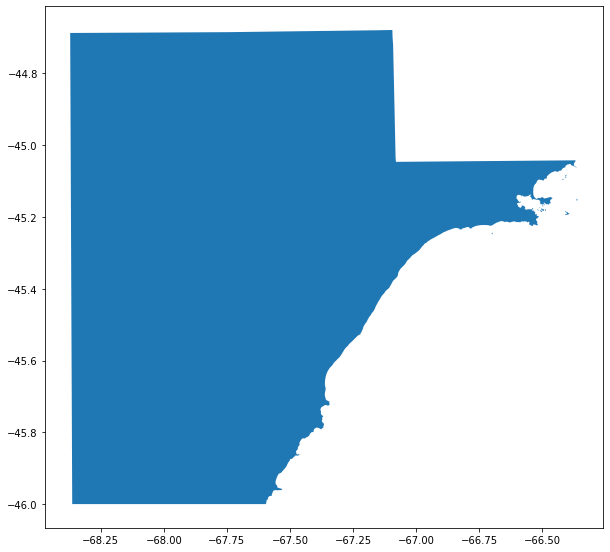

In [71]:
gdf = gpd.read_file('https://apis.datos.gob.ar/georef/api/departamentos?formato=shp&provincia=Chubut&max=5000&nombre=Escalante')
gdf
gdf.plot(figsize=(10,10))


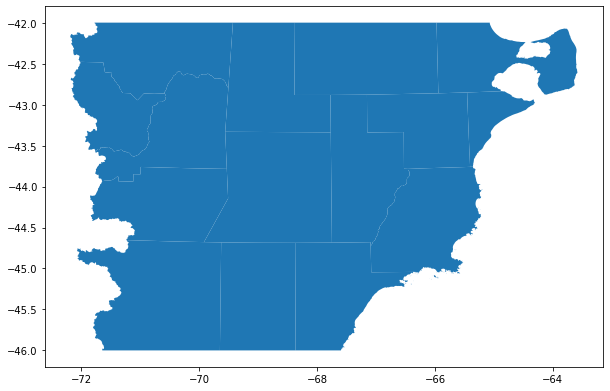

In [72]:
gdf = gpd.read_file('https://apis.datos.gob.ar/georef/api/departamentos?formato=shp&provincia=Chubut&max=5000')
gdf
gdf.plot(figsize=(10,10))

In [74]:
response = requests.get("https://apis.datos.gob.ar/georef/api/departamentos?provincia=Chubut")
response = response.json()
response

{'cantidad': 10,
 'departamentos': [{'centroide': {'lat': -43.1372229709113,
    'lon': -65.0757246833498},
   'id': '26077',
   'nombre': 'Rawson',
   'provincia': {'id': '26', 'nombre': 'Chubut'}},
  {'centroide': {'lat': -42.36635302228, 'lon': -70.7120117319755},
   'id': '26014',
   'nombre': 'Cushamen',
   'provincia': {'id': '26', 'nombre': 'Chubut'}},
  {'centroide': {'lat': -43.3234947781653, 'lon': -70.3484257364086},
   'id': '26056',
   'nombre': 'Languiñeo',
   'provincia': {'id': '26', 'nombre': 'Chubut'}},
  {'centroide': {'lat': -43.070540741803, 'lon': -71.4553756889394},
   'id': '26035',
   'nombre': 'Futaleufú',
   'provincia': {'id': '26', 'nombre': 'Chubut'}},
  {'centroide': {'lat': -44.2000353406651, 'lon': -70.5768950488331},
   'id': '26098',
   'nombre': 'Tehuelches',
   'provincia': {'id': '26', 'nombre': 'Chubut'}},
  {'centroide': {'lat': -45.282788434735, 'lon': -67.7087570024311},
   'id': '26021',
   'nombre': 'Escalante',
   'provincia': {'id': '26', '

,id,prov_nombre,nombre,geometry
0,06854,Buenos Aires,25 de Mayo,"POLYGON ((-60.02052 -35.10801, -60.01966 -35.1..."
1,06588,Buenos Aires,9 de Julio,"POLYGON ((-60.84118 -35.16618, -60.75045 -35.2..."
2,06007,Buenos Aires,Adolfo Alsina,"POLYGON ((-63.22224 -36.65733, -63.18597 -36.6..."
3,06014,Buenos Aires,Adolfo Gonzales Chaves,"POLYGON ((-60.37796 -37.66191, -60.42376 -37.6..."
4,06021,Buenos Aires,Alberti,"POLYGON ((-60.25068 -34.81797, -60.23983 -34.8..."
...,...,...,...,...
145,06847,Buenos Aires,Tres Lomas,"POLYGON ((-62.62602 -36.50150, -62.60647 -36.5..."
146,06861,Buenos Aires,Vicente López,"POLYGON ((-58.48037 -34.48861, -58.48036 -34.4..."
147,06868,Buenos Aires,Villa Gesell,"POLYGON ((-56.92596 -37.21009, -56.92604 -37.2..."
148,06875,Buenos Aires,Villarino,"MULTIPOLYGON (((-62.90019 -38.45579, -62.73822..."


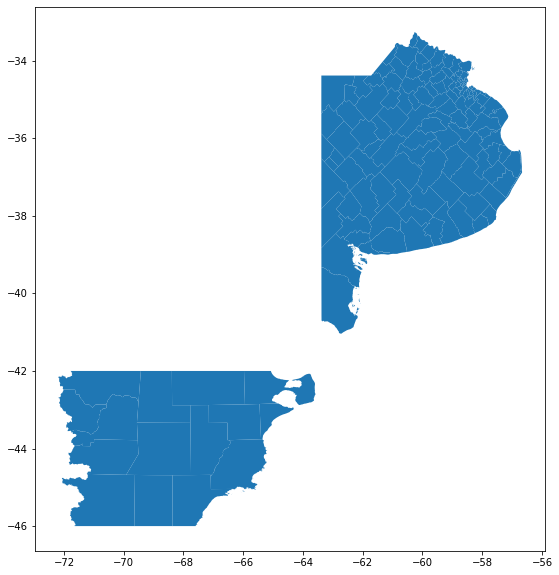

In [86]:
gdf = gpd.read_file('https://apis.datos.gob.ar/georef/api/departamentos?formato=shp&provincia=06,26&campos=nombre,provincia.nombre&max=5000&orden=nombre')
gdf.plot(figsize=(10,10))
gdf

### Normalización

#### Métodos POST y consultas bulk 

Los recursos se pueden usar para normalizar nombres de unidades territoriales mal escritos, corrigiendo con el nombre oficial y agregando el código oficial. Esto facilita enormemente la cruza de datos.

In [87]:
requests.get("https://apis.datos.gob.ar/georef/api/provincias?nombre=sant fe").json()

{'cantidad': 1,
 'inicio': 0,
 'parametros': {'nombre': 'sant fe'},
 'provincias': [{'centroide': {'lat': -30.7069271588117,
    'lon': -60.9498369430241},
   'id': '82',
   'nombre': 'Santa Fe'}],
 'total': 1}

Sin embargo, los datasets a normalizar generalmente tendrán muchas filas y el método GET en este caso no nos llevará muy lejos.. Consumiremos rápidamente la cuota de la API y no conseguiremos el objetivo.

Para esto podemos usar la versión "bulk" del recurso, y realizar una request POST.

Imaginemos que tenemos un dataset con varias filas a normalizar.

In [ ]:
bioetanol = pd.read_csv('http://datos.minem.gob.ar/dataset/5ce77ad1-c729-42cd-a8b5-2407de005e5b/resource/0df1eeda-854b-44b0-8ea6-1a537f167fa4/download/bioetanol.csv')

In [ ]:
bioetanol

,fecha,empresa,localidad,provincia,insumo,cupo_total_asignado_m3,produccion__m3,ventas_totales__m3,ventas_a_axion_m3,ventas_a_petrobras_m3,ventas_a_fox_petrol_m3,ventas_a_refineria_del_norte_m3,ventas_a_shell_m3,ventas_a_ypf_m3,ventas_a_energia_derivada_del_petroleo_m3,ventas_a_oil_combustibles_m3,ventas_a_trafigura_oil_m3
0,1/1/2012,ALCONOA S.R.L.,EL TABACAL,SALTA,CAÑA DE AZÚCAR,3500.0,6767.997473,3565.003159,298.00,0.00,0.0,0.00,1366.00,1901.00,0.00,0.00,0.0
1,1/1/2012,BIO SAN ISIDRO S.A.,CAMPO SANTO,SALTA,CAÑA DE AZÚCAR,300.0,0,476.651927,0.00,0.00,0.0,0.00,0.00,476.65,0.00,0.00,0.0
2,1/1/2012,BIOENERGÍA LA CORONA S.A.,CONCEPCIÓN,TUCUMÁN,CAÑA DE AZÚCAR,670.0,0,654.403032,0.00,0.00,0.0,0.00,0.00,654.41,0.00,0.00,0.0
3,1/1/2012,BIOENERGÍA SANTA ROSA S.A.,LEÓN ROUGES,TUCUMÁN,CAÑA DE AZÚCAR,1200.0,0,1051.345546,517.57,533.77,0.0,0.00,0.00,0.00,0.00,0.00,0.0
4,1/1/2012,BIOLEDESMA S.A.,LEDESMA,JUJUY,CAÑA DE AZÚCAR,4083.0,4391.787745,4278.686039,503.81,0.00,0.0,0.00,615.17,2645.09,104.36,410.27,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,3/1/2018,ENERGÍAS ECOLÓGICAS DEL TUCUMÁN S.A.,AGUILARES,TUCUMÁN,CAÑA DE AZÚCAR,NaN,1848.98,1704.720000,1194.33,0.00,0.0,0.00,510.39,0.00,0.00,0.00,0.0
968,3/1/2018,FRONTERITA ENERGÍA S.A.,FAMAILLÁ,TUCUMÁN,CAÑA DE AZÚCAR,NaN,463.5,2774.120000,1048.58,0.00,0.0,542.67,0.00,1182.87,0.00,0.00,0.0
969,3/1/2018,PROMAÍZ S.A.,ALEJANDRO ROCA,CÓRDOBA,MAÍZ,NaN,13904.27,12420.200000,3098.05,1301.97,0.0,0.00,2516.67,5503.51,0.00,0.00,0.0
970,3/1/2018,RÍO GRANDE ENERGÍA S.A.,LA MENDIETA,JUJUY,CAÑA DE AZÚCAR,NaN,1130.15,1573.470000,0.00,0.00,0.0,0.00,583.60,989.87,0.00,0.00,0.0


Los métodos POST se usan cuando una request debe enviarle datos al servidor para cumplir su cometido. Generalmente las POST requests generan cambios en el servidor (por ejemplo, agregan un comentario a una nota periodística) pero también se usan cuando la consulta requiere parámetros más complejos o voluminosos.

El método POST permite enviar un JSON (por ejemplo) aparte de la URL.

In [ ]:
data = {
    'provincias': [
        {
            'nombre': 'JUJUY',
            'max': 1,
            'campos': 'id,nombre'
        },
        {
            'nombre': 'TUCUMAN',
            'max': 1,
            'campos': 'id,nombre'
        },
        {
            'nombre': 'CORDOBA',
            'max': 1,
            'campos': 'id,nombre'
        },
        {
            'nombre': 'SALTA',
            'max': 1,
            'campos': 'id,nombre'
        }
    ]
}

En este diccionario, cada objeto en la lista de provincias es una consulta individual. Se pueden acumular hasta 1000 consultas en un solo POST request de esta API.

En todos los casos ponemos 'max' = 1 porque solo queremos el mejor match posible de cada caso, y elegimos que devuelva solo los campos que necesitamos, para agilizar la consulta.

In [ ]:
resultado_provs = requests.post(
    "https://apis.datos.gob.ar/georef/api/provincias",
    json=data
).json()

In [ ]:
resultado_provs

{'resultados': [{'cantidad': 1,
   'inicio': 0,
   'parametros': {'campos': ['id', 'nombre'], 'max': 1, 'nombre': 'JUJUY'},
   'provincias': [{'id': '38', 'nombre': 'Jujuy'}],
   'total': 1},
  {'cantidad': 1,
   'inicio': 0,
   'parametros': {'campos': ['id', 'nombre'], 'max': 1, 'nombre': 'TUCUMAN'},
   'provincias': [{'id': '90', 'nombre': 'Tucumán'}],
   'total': 1},
  {'cantidad': 1,
   'inicio': 0,
   'parametros': {'campos': ['id', 'nombre'], 'max': 1, 'nombre': 'CORDOBA'},
   'provincias': [{'id': '14', 'nombre': 'Córdoba'}],
   'total': 1},
  {'cantidad': 1,
   'inicio': 0,
   'parametros': {'campos': ['id', 'nombre'], 'max': 1, 'nombre': 'SALTA'},
   'provincias': [{'id': '66', 'nombre': 'Salta'}],
   'total': 1}]}

In [ ]:
resultado_provs['resultados'][0]['provincias']

[{'id': '38', 'nombre': 'Jujuy'}]

Para usar este método necesitamos generar el diccionario de una forma más flexible (no lo podemos hacer a mano!).

In [ ]:
provincias_normalizar = list(bioetanol.provincia)

In [ ]:
data = {
    'provincias': [
        {
            'nombre': provincia,
            'max': 1,
            'campos': 'id,nombre'
        }
        for provincia in provincias_normalizar
    ]
}

In [ ]:
resultado_provs = requests.post(
    "https://apis.datos.gob.ar/georef/api/provincias",
    json=data
).json()

In [ ]:
resultado_provs['resultados'][:10]

[{'cantidad': 1,
  'inicio': 0,
  'parametros': {'campos': ['id', 'nombre'], 'max': 1, 'nombre': 'SALTA'},
  'provincias': [{'id': '66', 'nombre': 'Salta'}],
  'total': 1},
 {'cantidad': 1,
  'inicio': 0,
  'parametros': {'campos': ['id', 'nombre'], 'max': 1, 'nombre': 'SALTA'},
  'provincias': [{'id': '66', 'nombre': 'Salta'}],
  'total': 1},
 {'cantidad': 1,
  'inicio': 0,
  'parametros': {'campos': ['id', 'nombre'], 'max': 1, 'nombre': 'TUCUMÁN'},
  'provincias': [{'id': '90', 'nombre': 'Tucumán'}],
  'total': 1},
 {'cantidad': 1,
  'inicio': 0,
  'parametros': {'campos': ['id', 'nombre'], 'max': 1, 'nombre': 'TUCUMÁN'},
  'provincias': [{'id': '90', 'nombre': 'Tucumán'}],
  'total': 1},
 {'cantidad': 1,
  'inicio': 0,
  'parametros': {'campos': ['id', 'nombre'], 'max': 1, 'nombre': 'JUJUY'},
  'provincias': [{'id': '38', 'nombre': 'Jujuy'}],
  'total': 1},
 {'cantidad': 1,
  'inicio': 0,
  'parametros': {'campos': ['id', 'nombre'], 'max': 1, 'nombre': 'TUCUMÁN'},
  'provincias': [{

In [ ]:
provincias_normalizadas = [
    resultado['provincias'][0]
    for resultado in resultado_provs['resultados']   
]

In [ ]:
provincias_normalizadas[:10]

[{'id': '66', 'nombre': 'Salta'},
 {'id': '66', 'nombre': 'Salta'},
 {'id': '90', 'nombre': 'Tucumán'},
 {'id': '90', 'nombre': 'Tucumán'},
 {'id': '38', 'nombre': 'Jujuy'},
 {'id': '90', 'nombre': 'Tucumán'},
 {'id': '90', 'nombre': 'Tucumán'},
 {'id': '90', 'nombre': 'Tucumán'},
 {'id': '38', 'nombre': 'Jujuy'},
 {'id': '66', 'nombre': 'Salta'}]

In [ ]:
df_provincias_normalizadas = pd.DataFrame(provincias_normalizadas)

In [ ]:
df_provincias_normalizadas

,id,nombre
0,66,Salta
1,66,Salta
2,90,Tucumán
3,90,Tucumán
4,38,Jujuy
...,...,...
967,90,Tucumán
968,90,Tucumán
969,14,Córdoba
970,38,Jujuy


In [ ]:
bioetanol['provincia_id'] = df_provincias_normalizadas['id']
bioetanol['provincia_nombre'] = df_provincias_normalizadas['nombre']

In [ ]:
def normalizar_unidades_territoriales(entidades, entidades_tipo):
    
    # genera el JSON con la lista de consultas a realizar
    data = {
        entidades_tipo: [
            {
                'nombre': nombre,
                'max': 1,
                'campos': 'id,nombre'
            }
            for nombre in entidades
        ]
    }
    
    # realiza la consulta
    resultados = requests.post(
        f"https://apis.datos.gob.ar/georef/api/{entidades_tipo}",
        json=data
    ).json()
    
    # parsea la respuesta
    entidades_normalizadas = [
        resultado[entidades_tipo][0]
        for resultado in resultados['resultados']   
    ]
    
    return pd.DataFrame(entidades_normalizadas)

**Ejercicio:** usá la función para normalizar las localidades del dataset. Qué te parece que puede estar mal en el resultado, en este caso?

Tal vez necesitemos modificar un poco la función para este caso. Como no queremos pasar todo el tiempo con este tema, en el módulo `helpers.py` te dejamos ya armada una funcion para normalizar distintas entidades usando la API Georef.

In [ ]:
localidades_normalizadas = helpers.normalizar_unidades_territoriales(
    bioetanol[['localidad', 'provincia']],
    entidades_tipo='localidades',
    nombre_campo='localidad',
    provincia_campo='provincia',
)

In [ ]:
localidades_normalizadas

,id,nombre,provincia_id,provincia_nombre
0,66126030000,EL TABACAL,66,Salta
1,66049010000,CAMPO SANTO,66,Salta
2,90021050000,CONCEPCION,90,Tucumán
3,None,None,None,None
4,38035080002,PUEBLO LEDESMA,38,Jujuy
...,...,...,...,...
967,90077010001,AGUILARES,90,Tucumán
968,90028030002,FAMAILLA,90,Tucumán
969,14056010000,ALEJANDRO ROCA,14,Córdoba
970,38063090000,LA MENDIETA,38,Jujuy


In [ ]:
bioetanol['localidad_id'] = df_provincias_normalizadas['id']
bioetanol['localidad_nombre'] = df_provincias_normalizadas['nombre']

### Georreferenciación 

En la API Georef, casi todos los recursos tienen una version GET (mas facil de usar, pero que permite hace pocas consultas) y una version POST (mas dificil de usar, pero que permite hacer mas consultas y mas eficientemente).

En las proximas dos secciones te vamos a presentar otras funcionalidades de la API Georef con el metodo GET correspondiente, y luego te ofreceremos una funcion ya escrita para hacer consultas masivas.

La funcion de **georreferenciacion** permite normalizar y descomponer una direccion de Argentina en partes, asi como obtener sus coordenadas.

In [ ]:
requests.get(
    'https://apis.datos.gob.ar/georef/api/direcciones?direccion=balcarce 50&provincia=02'
).json()

{'cantidad': 2,
 'direcciones': [{'altura': {'unidad': None, 'valor': 50},
   'calle': {'categoria': 'CALLE',
    'id': '0200701001910',
    'nombre': 'BALCARCE'},
   'calle_cruce_1': {'categoria': None, 'id': None, 'nombre': None},
   'calle_cruce_2': {'categoria': None, 'id': None, 'nombre': None},
   'departamento': {'id': '02007', 'nombre': 'Comuna 1'},
   'localidad_censal': {'id': '02000010',
    'nombre': 'Ciudad Autónoma de Buenos Aires'},
   'nomenclatura': 'BALCARCE 50, Comuna 1, Ciudad Autónoma de Buenos Aires',
   'piso': None,
   'provincia': {'id': '02', 'nombre': 'Ciudad Autónoma de Buenos Aires'},
   'ubicacion': {'lat': -34.6083411208197, 'lon': -58.37088525365451}},
  {'altura': {'unidad': None, 'valor': 50},
   'calle': {'categoria': 'CALLE',
    'id': '0204201005515',
    'nombre': 'FLORENCIO BALCARCE'},
   'calle_cruce_1': {'categoria': None, 'id': None, 'nombre': None},
   'calle_cruce_2': {'categoria': None, 'id': None, 'nombre': None},
   'departamento': {'id': 

No es obligatorio especificar una provincia, pero esto mejora mucho la precision del resultado. Tambien se puede especificar departamento u otros tipos de filtros. La API reconoce esquinas y diversas modalidades de especificar una direccion.

In [ ]:
requests.get(
    'https://apis.datos.gob.ar/georef/api/direcciones?direccion=santa fe y pueyrredon&provincia=02'
).json()

{'cantidad': 1,
 'direcciones': [{'altura': {'unidad': None, 'valor': None},
   'calle': {'categoria': 'AV',
    'id': '0201401001740',
    'nombre': 'AV SANTA FE'},
   'calle_cruce_1': {'categoria': 'AV',
    'id': '0201401001675',
    'nombre': 'AV PUEYRREDON'},
   'calle_cruce_2': {'categoria': None, 'id': None, 'nombre': None},
   'departamento': {'id': '02014', 'nombre': 'Comuna 2'},
   'localidad_censal': {'id': '02000010',
    'nombre': 'Ciudad Autónoma de Buenos Aires'},
   'nomenclatura': 'AV SANTA FE (ESQUINA AV PUEYRREDON), Comuna 2, Ciudad Autónoma de Buenos Aires',
   'piso': None,
   'provincia': {'id': '02', 'nombre': 'Ciudad Autónoma de Buenos Aires'},
   'ubicacion': {'lat': -34.5944399212952, 'lon': -58.4023531671055}}],
 'inicio': 0,
 'parametros': {'direccion': {'altura': {'unidad': None, 'valor': None},
   'calles': ['santa fe', 'pueyrredon'],
   'piso': None,
   'tipo': 'interseccion'},
  'provincia': ['02']},
 'total': 1}

In [ ]:
requests.get(
    'https://apis.datos.gob.ar/georef/api/direcciones?direccion=santa fe (esq pueyrredon)&provincia=02'
).json()

{'cantidad': 1,
 'direcciones': [{'altura': {'unidad': None, 'valor': None},
   'calle': {'categoria': 'AV',
    'id': '0201401001740',
    'nombre': 'AV SANTA FE'},
   'calle_cruce_1': {'categoria': 'AV',
    'id': '0201401001675',
    'nombre': 'AV PUEYRREDON'},
   'calle_cruce_2': {'categoria': None, 'id': None, 'nombre': None},
   'departamento': {'id': '02014', 'nombre': 'Comuna 2'},
   'localidad_censal': {'id': '02000010',
    'nombre': 'Ciudad Autónoma de Buenos Aires'},
   'nomenclatura': 'AV SANTA FE (ESQUINA AV PUEYRREDON), Comuna 2, Ciudad Autónoma de Buenos Aires',
   'piso': None,
   'provincia': {'id': '02', 'nombre': 'Ciudad Autónoma de Buenos Aires'},
   'ubicacion': {'lat': -34.5944399212952, 'lon': -58.4023531671055}}],
 'inicio': 0,
 'parametros': {'direccion': {'altura': {'unidad': None, 'valor': None},
   'calles': ['santa fe', 'pueyrredon'],
   'piso': None,
   'tipo': 'interseccion'},
  'provincia': ['02']},
 'total': 1}

**Ejercicio**: Genera un dataframe con direcciones para georreferenciar, que se pueda usar en la funcion de abajo. 

In [ ]:
# completa con direcciones y la provincia a la que pertenecen
direcciones = pd.DataFrame([
    {'direccion': 'balcarce 50', 'provincia': '02'},
    {'direccion': 'balcarce 50', 'provincia': '02'},
    {'direccion': 'balcarce 50', 'provincia': '02'},
    {'direccion': 'balcarce 50', 'provincia': '02'},
    {'direccion': 'balcarce 50', 'provincia': '02'},
])

In [ ]:
direcciones_georreferenciadas = helpers.georreferenciar_direcciones(
    direcciones[['direccion', 'provincia']],
    nombre_campo='direccion',
    provincia_campo='provincia',
)
direcciones_georreferenciadas

,direccion_normalizada,latitud,longitud,provincia_id,provincia_nombre
0,"BALCARCE 50, Comuna 1, Ciudad Autónoma de Buen...",-34.608341,-58.370885,02,Ciudad Autónoma de Buenos Aires
1,"BALCARCE 50, Comuna 1, Ciudad Autónoma de Buen...",-34.608341,-58.370885,02,Ciudad Autónoma de Buenos Aires
2,"BALCARCE 50, Comuna 1, Ciudad Autónoma de Buen...",-34.608341,-58.370885,02,Ciudad Autónoma de Buenos Aires
3,"BALCARCE 50, Comuna 1, Ciudad Autónoma de Buen...",-34.608341,-58.370885,02,Ciudad Autónoma de Buenos Aires
4,"BALCARCE 50, Comuna 1, Ciudad Autónoma de Buen...",-34.608341,-58.370885,02,Ciudad Autónoma de Buenos Aires


### Georreferenciación inversa 

La funcionalidad de **georreferenciacion inversa** toma un punto de coordenadas y devuelve aquellas unidades territoriales que lo contienen.

No es esctrictamente una funcion georreferenciacion inversa en realidad, ya que no devuelve una aproximacion de la direccion a la que pertenece ese punto de coordenadas, solo devuelve las unidades territoriales que contienen al punto.

Esta funcion es muy util cuando ya se tiene un dataset con coordenadas, pero queremos tener tambien las columnas de provincias, departamentos y municipios.

In [ ]:
requests.get(
    'https://apis.datos.gob.ar/georef/api/ubicacion?lat=-34.6037389&lon=-58.3815704'
).json()

{'parametros': {'lat': -34.6037389, 'lon': -58.3815704},
 'ubicacion': {'departamento': {'id': '02007', 'nombre': 'Comuna 1'},
  'lat': -34.6037389,
  'lon': -58.3815704,
  'municipio': {'id': None, 'nombre': None},
  'provincia': {'id': '02', 'nombre': 'Ciudad Autónoma de Buenos Aires'}}}

In [ ]:
requests.get(
    'https://apis.datos.gob.ar/georef/api/ubicacion?lat=-32.9477132&lon=-60.6304658'
).json()

{'parametros': {'lat': -32.9477132, 'lon': -60.6304658},
 'ubicacion': {'departamento': {'id': '82084', 'nombre': 'Rosario'},
  'lat': -32.9477132,
  'lon': -60.6304658,
  'municipio': {'id': None, 'nombre': None},
  'provincia': {'id': '82', 'nombre': 'Santa Fe'}}}

In [ ]:
requests.get(
    'https://apis.datos.gob.ar/georef/api/ubicacion?lat=-38.0048387&lon=-57.5483175'
).json()

{'parametros': {'lat': -38.0048387, 'lon': -57.5483175},
 'ubicacion': {'departamento': {'id': '06357', 'nombre': 'General Pueyrredón'},
  'lat': -38.0048387,
  'lon': -57.5483175,
  'municipio': {'id': '060357', 'nombre': 'General Pueyrredón'},
  'provincia': {'id': '06', 'nombre': 'Buenos Aires'}}}

Por ejemplo, si tenemos las coordenadas de todos los aeropuertos del pais, podemos agregarle facilmente los codigos y nombres oficiales de las provincias, departamentos y municipios que los contienen.

In [ ]:
aeropuertos = pd.read_csv(
    'https://servicios.transporte.gob.ar/gobierno_abierto/descargar.php?t=aeropuertos&d=detalle',
    sep=';'
)

In [ ]:
aeropuertos

,local,oaci,iata,tipo,denominacion,coordenadas,latitud,longitud,elev,uom_elev,...,condicion,control,region,fir,uso,trafico,sna,concesionado,provincia,inhab
0,ACB,NaN,NaN,Aeródromo,CORONEL BOGADO/AGROSERVICIOS,"33°16'20""S 60°34'14""W",-60.570660,-33.272260,44.0,Metros,...,PRIVADO,NOCONTROL,RACE,SAEF,AEROAPP,Nacional,NO,NO,SANTA FÉ,NO
1,ACH,NaN,NaN,Aeródromo,GENERAL ACHA,"37°24' 6""S 64°36'49""W",-64.613510,-37.401640,277.0,Metros,...,PUBLICO,NOCONTROL,RACE,SAEF,CIVIL,Nacional,NO,NO,LA PAMPA,NO
2,ACM,NaN,NaN,Aeródromo,ARRECIFES/LA CURA MALAL,"34° 4'33""S 60° 8'30""W",-60.141700,-34.075740,37.0,Metros,...,PRIVADO,NOCONTROL,RACE,SAEF,CIVIL,Nacional,NO,NO,BUENOS AIRES,NO
3,ADO,SAWD,PUD,Aeródromo,PUERTO DESEADO,"47°44' 6""S 65°54'15""W",-65.904100,-47.735110,82.0,Metros,...,PUBLICO,AERADIO,RASU,SAVF,CIVIL,Nacional,NO,NO,SANTA CRUZ,NO
4,ADT,NaN,NaN,Aeródromo,BANDERA/AGROSERVICIOS DOÑA TERESA,"28°51'19""S 62°15'53""W",-62.264620,-28.855410,75.0,Metros,...,PRIVADO,NOCONTROL,RANO,SACF,AEROAPP,Nacional,NO,NO,SANTIAGO DEL ESTERO,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,YOS,SAZH,OYO,Aeródromo,TRES ARROYOS,"38°23' 8""S 60°19'39""W",-60.327500,-38.385556,122.0,Metros,...,PUBLICO,NOCONTROL,RACE,SAEF,NaN,Nacional,NO,NO,BUENOS AIRES,NO
689,YPY,NaN,NaN,Aeródromo,YAPEYÚ,"29°21'32""S 56°47'45""W",-56.795730,-29.358770,53.0,Metros,...,PRIVADO,NOCONTROL,RANE,SARR,NaN,Nacional,NO,NO,CORRIENTES,NO
690,ZAP,SAHZ,APZ,Aeródromo,ZAPALA,"38°58'33""S 70° 6'48""W",-70.113464,-38.975886,1048.0,Metros,...,PUBLICO,NOCONTROL,RACE,SAEF,NaN,Nacional,NO,NO,NEUQUÉN,NO
691,ZLM,NaN,NaN,Aeródromo,BELL VILLE/LA ZULEMA,"32°29'23""S 62°40'17""W",-62.671389,-32.489722,129.0,Metros,...,PRIVADO,NOCONTROL,RANO,SACF,AEROAPP,Nacional,NO,NO,CÓRDOBA,NO


Notemos que el dataset tiene un error! Los nombres de las columnas latitud y longitud, estan invertidos.

In [ ]:
lat = aeropuertos.iloc[0]['latitud']
lon = aeropuertos.iloc[0]['longitud']

requests.get(
    f'https://apis.datos.gob.ar/georef/api/ubicacion?lat={lat}&lon={lon}'
).json()

{'parametros': {'lat': -60.57066, 'lon': -33.27226},
 'ubicacion': {'departamento': {'id': None, 'nombre': None},
  'lat': -60.57066,
  'lon': -33.27226,
  'municipio': {'id': None, 'nombre': None},
  'provincia': {'id': None, 'nombre': None}}}

In [ ]:
lat = aeropuertos.iloc[0]['longitud']
lon = aeropuertos.iloc[0]['latitud']

requests.get(
    f'https://apis.datos.gob.ar/georef/api/ubicacion?lat={lat}&lon={lon}'
).json()

{'parametros': {'lat': -33.27226, 'lon': -60.57066},
 'ubicacion': {'departamento': {'id': '82084', 'nombre': 'Rosario'},
  'lat': -33.27226,
  'lon': -60.57066,
  'municipio': {'id': '823393', 'nombre': 'Coronel Bogado'},
  'provincia': {'id': '82', 'nombre': 'Santa Fe'}}}

Alcanza con notar esto para poder especifiar los nombres invertidos en la funcion.

In [ ]:
unidades_territoriales = helpers.ubicar_coordenadas(
    aeropuertos[['latitud', 'longitud']],
    'longitud', 'latitud'
)
unidades_territoriales

,provincia_id,provincia_nombre,departamento_id,departamento_nombre,municipio_id,municipio_nombre
0,82,Santa Fe,82084,Rosario,823393,Coronel Bogado
1,42,La Pampa,42154,Utracán,420133,General Acha
2,06,Buenos Aires,06077,Arrecifes,060077,Arrecifes
3,78,Santa Cruz,78014,Deseado,None,None
4,86,Santiago del Estero,86077,General Taboada,None,None
...,...,...,...,...,...,...
688,06,Buenos Aires,06833,Tres Arroyos,060833,Tres Arroyos
689,18,Corrientes,18147,San Martín,180378,Yapeyú
690,58,Neuquén,58112,Zapala,580245,Zapala
691,14,Córdoba,14182,Unión,None,None


**Ejercicio**: ubica las coordenadas de las estaciones de medicion de recursos hidricos (https://datos.mininterior.gob.ar/dataset/93913deb-d22e-4c0d-bca3-f465e7b2bb94/resource/26d292a4-4d7f-48e1-872a-50a0dca35386/download/estacioneslatlong.csv) en sus unidades territoriales. Tene en cuenta que este dataset **esta codificado en 'latin1'**. Tenes que especificar la codificacion en la llamada pd.read_csv() para que lo lea sin errores.

##  API Nominatim

https://nominatim.org/

Por supuesto, la API Georef del Estado Nacional no es la unica API de georreferenciacion que podes usar, existen muchas otras con distintos alcances y funcionalides.

La API de Nominativa, utiliza la base de datos de la iniciativa Open Street Map para proveer un servicio abierto de georreferenciacion con alcance global.

Es importante que si usas esta API regularmente, leas los [terminos y condiciones](https://operations.osmfoundation.org/policies/nominatim/). Entre ellas no permite hacer mas de 1 request por segundo, debe citarse la fuente y no se permite el uso para geocodificacion bulk. Esta API es para usar en forma esporadica, pero no en produccion (salvo que se instale la API en infraestructura propia).

Podes leer la documentacion de uso de la API, aca: https://nominatim.org/release-docs/develop/api/Overview/

### Busqueda de objetos en el espacio 

Uno de los usos de la API es buscar objetos en el espacio, funciona de manera parecida a como a veces usamos Google Maps. Le podemos decir 'escuelas en berlin', 'hospitales en montevideo' y otras cosas parecidas, y devolvera una lista de resultados de lo que encuentre.

In [ ]:
# hospitales en Montevideo
requests.get(
    'https://nominatim.openstreetmap.org/?addressdetails=1&q=hospitales+en+montevideo+uruguay&format=json&limit=3'
).json()

[{'place_id': 105865581,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'way',
  'osm_id': 82097653,
  'boundingbox': ['-34.8966773', '-34.89491', '-56.1646663', '-56.1639028'],
  'lat': '-34.895802849999995',
  'lon': '-56.16432162417556',
  'display_name': 'Hospital Italiano Umberto I, Bulevar General Artigas, Villa Muñoz, La Blanqueada, Montevideo, 11601, Uruguay',
  'class': 'amenity',
  'type': 'hospital',
  'importance': 0.5913602540314964,
  'icon': 'https://nominatim.openstreetmap.org/images/mapicons/health_hospital.p.20.png',
  'address': {'amenity': 'Hospital Italiano Umberto I',
   'road': 'Bulevar General Artigas',
   'neighbourhood': 'Villa Muñoz',
   'suburb': 'La Blanqueada',
   'city': 'Montevideo',
   'state': 'Montevideo',
   'postcode': '11601',
   'country': 'Uruguay',
   'country_code': 'uy'}},
 {'place_id': 128059963,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_

**Ejercicio:** genera una lista de nombres y direcciones de hospitales en la Ciudad de Buenos Aires, a partir de la API de Nominatim.

### Georreferenciacion inversa

El recurso /reverse permite recuperar una direccion, a partir de un par de coordenadas.

In [ ]:
requests.get(
    'https://nominatim.openstreetmap.org/reverse?format=jsonv2&lat=-34.6083411208197&lon=-58.37088525365451'
).json()

{'place_id': 14124008,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 208809079,
 'lat': '-34.6090457',
 'lon': '-58.3709109',
 'place_rank': 30,
 'category': 'place',
 'type': 'house',
 'importance': -0.1,
 'addresstype': 'place',
 'name': None,
 'display_name': '302, Avenida Hipólito Yrigoyen, Monserrat, Buenos Aires, Ciudad Autónoma de Buenos Aires, Comuna 1, C1086AAD, Argentina',
 'address': {'house_number': '302',
  'road': 'Avenida Hipólito Yrigoyen',
  'suburb': 'Monserrat',
  'city': 'Buenos Aires',
  'state_district': 'Comuna 1',
  'postcode': 'C1086AAD',
  'country': 'Argentina',
  'country_code': 'ar'},
 'boundingbox': ['-34.6090957', '-34.6089957', '-58.3709609', '-58.3708609']}

**Ejercicio:** usa alguna de las coordenadas de las estaciones de medicion hidricas, para encontrar su direccion con este metodo. Funciona? Que resultados da esta API para esos casos?

### Chequea el estado del servicio 

Si la API no parece funcionar, podes asegurarte consultando si el servicio esta funcionando en este momento o no.

In [ ]:
requests.get(
    'https://nominatim.openstreetmap.org/status.php?format=json'
).json()

{'status': 0, 'message': 'OK', 'data_updated': '2020-07-30T20:04:01+00:00'}

## API normalización GCBA

https://usig.buenosaires.gob.ar/apis/

Si lo que necesitas hacer tiene un alcance acotado al Area Metropolitana de Buenos Aires (AMBA), tambien podes usar la API de normalizacion de direcciones del AMBA del Gobierno de la Ciudad de Buenos Aires. Una ventaja que tiene este servicio, es que tambien lo podes instalar como una libreria de python para no necesitar internet ni tener limite de cuotas (https://github.com/usig/normalizador-amba).

### Georreferenciacion 

In [ ]:
requests.get(
    'https://ws.usig.buenosaires.gob.ar/rest/normalizar_y_geocodificar_direcciones?calle=balcarce&altura=50&desambiguar=1'
).json()

{'Normalizacion': {'TipoResultado': 'DireccionNormalizada',
  'DireccionesCalleAltura': {'direcciones': [{'CodigoCalle': '2014',
     'Calle': 'BALCARCE',
     'Altura': '50'}]},
  'DireccionesCalleCalle': {'direcciones': []}},
 'GeoCodificacion': {'x': '108487.447694', 'y': '102343.772587'}}

La API de normalizacion de la USIG del GCBA devuelve coordenadas en el sistema de proyeccion Buenos Aires Gauss Krueguer, que es mas preciso para trabajar dentro del espacio geografico de la CABA pero tambien menos facil de usar para otros usos.

Hay otro recurso de la API que transforma esas coordenadas en EPSG 4326 (el sistema de coordenadas al que estamos mas acostumbrados).

In [ ]:
requests.get(
    'https://ws.usig.buenosaires.gob.ar/rest/convertir_coordenadas?x=108487.447694&y=102343.772587&output=lonlat'
).json()

{'tipo_resultado': 'Ok', 'resultado': {'x': '-58.370769', 'y': '-34.608107'}}

### Datos utiles 

Otro metodo de las APIs de USIG devuelve datos utiles del contexto de una direccion. Es parecido al de 'ubicacion' de la API Georef, pero tiene otras areas / unidades territoriales que contienen al punto, y son propias del AMBA.

In [ ]:
requests.get(
    'https://ws.usig.buenosaires.gob.ar/datos_utiles?calle=balcarce&altura=50'
).json()

{'comuna': 'Comuna 1',
 'barrio': 'Monserrat',
 'comisaria': '2',
 'area_hospitalaria': 'HTAL. DR. C. ARGERICH',
 'region_sanitaria': 'I (Este)',
 'distrito_escolar': 'Distrito Escolar   IV',
 'comisaria_vecinal': '1D',
 'seccion_catastral': '02',
 'distrito_economico': '',
 'codigo_de_planeamiento_urbano': '',
 'partido_amba': '',
 'localidad_amba': '',
 'codigo_postal': '1064',
 'codigo_postal_argentino': 'C1064AAB'}

## API Transporte GCBA

https://www.buenosaires.gob.ar/desarrollourbano/transporte/apitransporte

La API unificada de transporte del GCBA ofrece acceso en tiempo real a las localizaciones de subtes, colectivos, trenes, monopatines y otros muchos datos sobre la movilidad en la Ciudad de Buenos Aires. Es gratuita pero requiere registrarse y usar credenciales para cada consulta.

Una vez registrado, tenes que guardar tus credenciales en un archivo JSON `api_transporte_creds.json` en el directorio de este notebook, o copiarlas directamente en la URL de la llamada.

In [ ]:
# carga credenciales
with open('api_transporte_creds.json', 'r') as f:
    creds = json.load(f)

In [ ]:
client_id = creds['client_id']
client_secret = creds['client_secret']

In [ ]:
colectivos_ahora = requests.get(
    f'https://apitransporte.buenosaires.gob.ar/colectivos/vehiclePositionsSimple?client_id={client_id}&client_secret={client_secret}'
).json()
colectivos_ahora[:5]

[{'route_id': '3712',
  'latitude': -34.65343,
  'longitude': -58.6448059,
  'speed': 0,
  'timestamp': 1596139450,
  'id': '1838',
  'direction': 0,
  'agency_name': 'MICROOMNIBUS SAAVEDRA S.A.T.A.C.I.',
  'agency_id': 82,
  'route_short_name': '321A',
  'trip_headsign': 'a LIBERTAD'},
 {'route_id': '3713',
  'latitude': -34.67617,
  'longitude': -58.6695747,
  'speed': 0,
  'timestamp': 1596139420,
  'id': '1839',
  'direction': 1,
  'agency_name': 'MICROOMNIBUS SAAVEDRA S.A.T.A.C.I.',
  'agency_id': 82,
  'route_short_name': '153A',
  'trip_headsign': 'a Liniers'},
 {'route_id': '3713',
  'latitude': -34.63905,
  'longitude': -58.52692,
  'speed': 3.055555,
  'timestamp': 1596139450,
  'id': '1844',
  'direction': 0,
  'agency_name': 'MICROOMNIBUS SAAVEDRA S.A.T.A.C.I.',
  'agency_id': 82,
  'route_short_name': '153A',
  'trip_headsign': 'a Bº Nuevo'},
 {'route_id': '3713',
  'latitude': -34.65006,
  'longitude': -58.61392,
  'speed': 0,
  'timestamp': 1596139450,
  'id': '1845',
  

In [ ]:
gdf = gpd.GeoDataFrame(colectivos_ahora)

In [ ]:
gdf['geometry'] = gpd.points_from_xy(gdf.longitude, gdf.latitude)

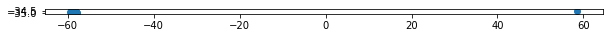

In [ ]:
gdf.plot(figsize=(10, 10))

In [ ]:
lineas = gdf.groupby(['route_short_name']).count()

In [ ]:
lineas.sort_values('id', ascending=False).head(20)

,route_id,latitude,longitude,speed,timestamp,id,direction,agency_name,agency_id,trip_headsign,geometry
route_short_name,,,,,,,,,,,
343A,78,78,78,78,78,78,78,78,78,78,78
329TR1,57,57,57,57,57,57,57,57,57,57,57
53C,48,48,48,48,48,48,48,48,48,48,48
12A,47,47,47,47,47,47,47,47,47,47,47
41A,44,44,44,44,44,44,44,44,44,44,44
92A,42,42,42,42,42,42,42,42,42,42,42
152A,41,41,41,41,41,41,41,41,41,41,41
67A,36,36,36,36,36,36,36,36,36,36,36
10A,33,33,33,33,33,33,33,33,33,33,33


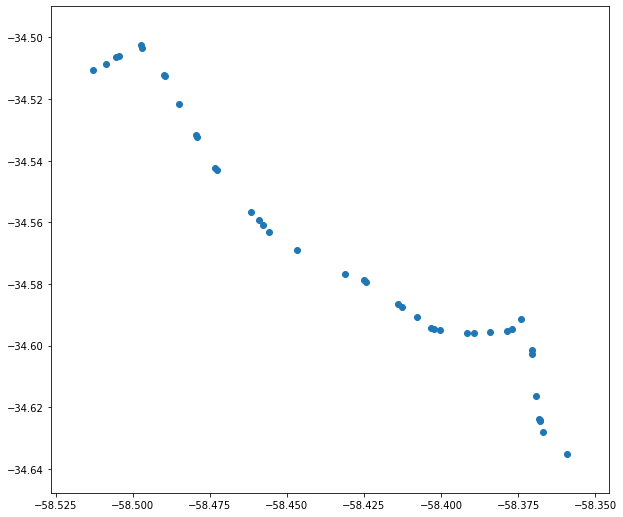

In [ ]:
gdf[gdf.route_short_name == '152A'].plot(figsize=(10, 10))